In [ ]:
# CONSTANTS & IMPORTS
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import cv2
import seaborn as sns;sns.set()

IMAGE_SIZE = (2866, 2633, 3)
NUM_OF_DAYS = 23
CLASSES = ["urban areas", "other built-up surfaces", "forests", 
           "sparse vegetation", "rocks and bare soil", "grassland", 
           "sugarcane crops", "other crops", "water"]
FEATURES = [
    "ultra blue","blue","green","red","NIR","SWIR1","SWIR2","NDVI","NDWI","BI"
]

NUM_OF_CLASSES = len(CLASSES)
NUM_OF_FEATURES = len(FEATURES)
NUM_OF_PIXELS = 81714

In [ ]:
# DATA LOADING
data = pd.read_csv("/content/training.txt", header=None)
coord = pd.read_csv("/content/coord_training.txt", header=None)
classes_val = pd.read_csv("/content/train_class.txt", header=None)

data_test = pd.read_csv("/content/test.txt", header=None)
coord_test = pd.read_csv("/content/coord_test.txt", header=None)
classes_val_test = pd.read_csv("/content/test_class.txt", header=None)
y_test = classes_val_test.to_numpy()

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Concatenate, Conv1D, MaxPooling1D
from tensorflow.keras.layers import LSTM, Flatten

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau 

## Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

LR = 0.001
BATCH_SIZE = 256
EPOCHS = 50
VAL_SIZE = 0.1

In [ ]:
from tensorflow.keras.layers import Conv1D, Input, Concatenate, GlobalMaxPooling1D, MaxPooling1D
from tensorflow.keras.models import Model

LR = 0.01
BATCH_SIZE = 256
EPOCHS = 100
VAL_SIZE = 0.2
DOWN_SAMPLING_FACTOR = 2
DOWN_SAMPLING_SIZE = int(np.ceil(NUM_OF_DAYS)/DOWN_SAMPLING_FACTOR) + 1
SMOOTH_SIZE = 4

scaler = StandardScaler()

In [ ]:
# Formatting the X data
data_train = data.to_numpy()
X = data_train.reshape((NUM_OF_PIXELS, 23, NUM_OF_FEATURES)).astype(np.int64)
coord_np = coord.to_numpy().astype(np.int64).reshape(-1, 2)
idx = np.arange(X.shape[0])

# Formatting the y data
classes_train = classes_val.to_numpy().astype(np.int64)
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y = enc.fit_transform(classes_train).astype(np.int64)

In [ ]:
# Splitting x and y into training and validation sets
#X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(X, y, idx, test_size=VAL_SIZE)

In [ ]:
def get_base_model(input_len, fsize=6):
    #this base model represents the convolution + pooling phase (there will be three of it)

    input_seq = Input(shape=(input_len, 10))

    x = Conv1D(40, fsize, padding="same", activation="relu")(input_seq)
    x = MaxPooling1D()(x)
    model = Model(inputs=input_seq, outputs=x)
    
    return model

def get_coord_model():
    input_c = Input(shape=(2,))
    model = Model(inputs=input_c, outputs=input_c)
    
    return model

#it takes the original time series and its down-sampled versions as an input, and returns the result of classification as an output
def get_1D_CNN():

    input_original = Input(shape=(23, 10))
    input_multifrequency = Input(shape=(23 , 10))
    input_down_sampling = Input(shape=(DOWN_SAMPLING_SIZE, 10))
    
    base_net_original = get_base_model(23)
    base_net_multifrequency = get_base_model(23)
    base_net_down_sampling = get_base_model(DOWN_SAMPLING_SIZE, fsize=3)
    
    embedding_original = base_net_original(input_original)
    embedding_multifrequency = base_net_multifrequency(input_multifrequency)
    embedding_down_sampling = base_net_down_sampling(input_down_sampling)
    
    merged = Concatenate(axis=1)([embedding_original, embedding_multifrequency, embedding_down_sampling])#concatenate all the outputs
    
    conv = Conv1D(40, 6, padding="same", activation="relu")(merged)
    x = GlobalMaxPooling1D()(conv)
    
    coord_model = get_coord_model()
    #concatenating the coord model and the CNN-extracted features
    x = Concatenate(axis=-1)([x, coord_model.output])
    x = Dense(256, activation="relu")(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation="relu")(x)
    #x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation="relu")(x)
    
    out = Dense(NUM_OF_CLASSES, activation='softmax')(x)
    
    model = Model(inputs=[input_original, input_multifrequency, input_down_sampling, coord_model.input], outputs=out)
    return model

In [ ]:
def smoothing(row):
    # given a row of shape (23,10), smoothes all 10 feature according to the smoothing factor (mean over a SMOOTH_SIZE window)
    
    to_smooth = np.copy(row)
    
    for i in range(row.shape[1]):
        for j in range(row.shape[0]):
            
            smoothing_indices = np.array([k % row.shape[0] for k in range(int(j - SMOOTH_SIZE / 2), int(j + SMOOTH_SIZE / 2 + 1))])
            
            acc = 0
            for idx in smoothing_indices:
                acc += row[idx,i]
                
            to_smooth[j,i] = acc / SMOOTH_SIZE
            
    return to_smooth

def down_sampling(row):
    new_row = []
    
    for j in range(0, len(row)+1, DOWN_SAMPLING_FACTOR):
        new_row.append(row[j])
    
    return np.array(new_row)

In [ ]:
def data_generator(X, y, input_shape=(23,10), batch_size=64):
    """
        X is a tuple (X_train, X_coord) where X_train is the pixels data and X_coord their coordinates
    """
    X_train, X_coord = X
    
    while True:
        
        for i in range(0, len(X_train), batch_size):
            
            upper = min(i+batch_size, len(X_train)-1)
            
            batch = np.copy(X_train[i:upper])
            smoothed = np.copy(X_train[i:upper])
            down_sampled = np.zeros((len(batch),DOWN_SAMPLING_SIZE,input_shape[1]))
            coords = np.copy(X_coord[i:upper])
            
            for row_idx in range(len(batch)):
                smoothed[row_idx, :] = smoothing(X_train[row_idx, :])
                down_sampled[row_idx, :] = down_sampling(X_train[row_idx, :])
            
            
            X_batch = [
                batch,smoothed,down_sampled, coords
            ]
            
            y_batch = y[i:upper]
                
            yield X_batch, y_batch
#Training our model

train_gen = data_generator(
    (X_train,coord_train), y_train, batch_size=BATCH_SIZE)
val_gen = data_generator(
    (X_val,coord_val), y_val, batch_size=BATCH_SIZE)
train_steps = round(len(X_train) / BATCH_SIZE) + 1
val_steps = round(len(X_val) / BATCH_SIZE) + 1

model = get_1D_CNN()

opt = Adam(LR)
model.compile(opt, loss="categorical_crossentropy",
    metrics=['categorical_accuracy'])

model_filename = "tiselac-1d-cnn-{epoch:02d}-{val_loss:.2f}.h5"

callbacks = [
    ModelCheckpoint(
        os.path.join("models/", model_filename),
        monitor='val_loss', verbose=1, save_best_only=True, save_freq='epoch'),
    EarlyStopping(monitor='val_loss', min_delta = 1e-3, patience = 5),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1,
                              patience=3, min_lr=0.00001)

]

model.fit_generator(
    train_gen,
    steps_per_epoch=train_steps,
    epochs=EPOCHS,
    validation_data=val_gen,
    validation_steps=val_steps,
    callbacks=callbacks
)

In [ ]:
#Testing the model
from sklearn.metrics import f1_score

data_test_np = data_test.to_numpy()

X_test = data_test_np.reshape((data_test_np.shape[0], 23, NUM_OF_FEATURES)).astype(np.float32)
coord_test_np = coord_test.to_numpy().astype(np.int32).reshape(-1, 2)
coord_test_np = scaler.transform(coord_test_np)

test_gen = data_generator((X_test,coord_test_np), y_test, batch_size=BATCH_SIZE)
test_steps = round(len(X_test) / BATCH_SIZE) + 1

y_pred = model.predict_generator(test_gen, steps=test_steps)
y_pred = np.argmax(y_pred, axis=1) +1

f1_score(y_test.flatten()[:17972], y_pred, average="weighted")

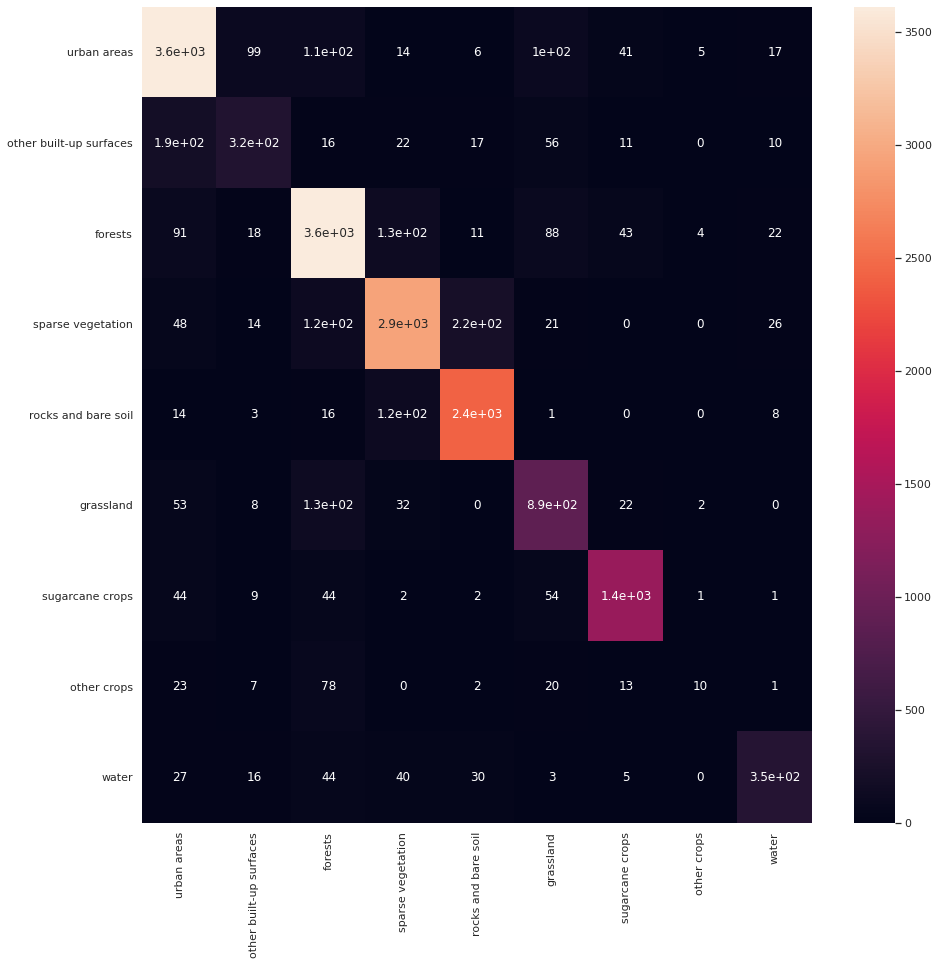

In [ ]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix
m = confusion_matrix(y_test.flatten()[:-1], y_pred)
m_pd = pd.DataFrame(m)
classes_as_dict = {i: CLASSES[i] for i in range(9)}
m_pd = m_pd.rename(columns=classes_as_dict, index=classes_as_dict)

figs, axs = plt.subplots(figsize=(15,15))
sns.heatmap(m_pd, ax=axs, annot=True)